# Recommendation Systems Using Collaborative filtering Approach
We use Model base collaborative filtering approach using the K-nearest neighbour algorithm to buil our product recommendation system.

## Outline
  1. Setup
  1. Downloading dataset
  1. Exploring the Data
  1. Building the Model

# Setup

##Importing Required Libraries
- gzip, urlopen and json libraries are required because our dataset is in the json.gz format 
- numpy and pandas are used to work with dataframe and to do mathematical calculations
- matplotlib is used to visualize our dataset


In [ ]:
import os
import json
import gzip
from urllib.request import urlopen

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
##  Add some convinience function to pandas dataframe

pd.options.display.max_rows = 10
pd.set_option('display.float_format', lambda x: '%.3f' % x)

##Defining Constants


1.   no_of_ratings - The no of ratings to use from the 10,063,255 ratings in our ratings dataset
3. popularity_threshold - our self defined threshold to filter product based on number of obtained ratings
4. metric - metric to be used in the knn algorithm
5. algorithm - algorithm to be used in the knn algorithm
6. n_neighbours - no of neighbours to consider in knn





In [ ]:
no_of_ratings = 100000
popularity_threshold = 100
metric = 'cosine'
algorithm = 'brute'
n_neighbors = 10

#Downloading Dataset and setting up dataframe
 - we are using the Amazon 2018 product_rating (ratings only) and product_metadata dataset available at : https://nijianmo.github.io/amazon/index.html
 - The metadata dataset is present in the json.gz format and contains all the meta information regarding the product 
  - eg; product_id, name, price, category, description, brand, etc.
 - It contains 590,269 product details
 - The ratings dataset is present in the csv format and contains user, item, rating, timestamp tuples and contains 10,063,255 ratings of products

 

In [ ]:
# ##  Downloading the dataset
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Cell_Phones_and_Accessories.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories.csv

--2020-10-07 09:12:22--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Cell_Phones_and_Accessories.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348993553 (333M) [application/octet-stream]
Saving to: ‘meta_Cell_Phones_and_Accessories.json.gz.2’

meta_Cell_Phones_an 100%[===================>] 332.83M  5.33MB/s    in 41s     

2020-10-07 09:13:03 (8.04 MB/s) - ‘meta_Cell_Phones_and_Accessories.json.gz.2’ saved [348993553/348993553]

--2020-10-07 09:13:04--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420031077 (401M) [application/octet-stream]
Saving to: ‘Cell_Phones_and_

## Products Dataset

In [ ]:
##  utility method to convert json.gz file into a dataframe
'''
  Args: 
    file_name : The name/URL of the file in json.gz format 
  Returns : 
    df : file converted into a pandas dataframe
'''
def gzipConverter(file_name):
  data = []
  with gzip.open(file_name) as f:
      for l in f:
          data.append(json.loads(l.strip()))
  print("The Dataset "+file_name+" has "+str(len(data))+" examples")
  df = pd.DataFrame.from_dict(data)
  return df

In [ ]:
##  Converting files to dataframe by calling our utility method
products = gzipConverter("meta_Cell_Phones_and_Accessories.json.gz")
products.info() # .info() gives info about columns of the dataset like the (no. of null and non-null values and data type)

The Dataset meta_Cell_Phones_and_Accessories.json.gz has 590071 examples
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590071 entries, 0 to 590070
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      590071 non-null  object
 1   tech1         590071 non-null  object
 2   description   590071 non-null  object
 3   fit           590071 non-null  object
 4   title         590071 non-null  object
 5   also_buy      590071 non-null  object
 6   image         590071 non-null  object
 7   tech2         590071 non-null  object
 8   brand         590071 non-null  object
 9   feature       590071 non-null  object
 10  rank          590071 non-null  object
 11  also_view     590071 non-null  object
 12  details       590071 non-null  object
 13  main_cat      590071 non-null  object
 14  similar_item  590071 non-null  object
 15  date          590071 non-null  object
 16  price         590071 non-null  object

In [ ]:
##  Since, our dataset may Contain duplicates we check for unique values

print("Number of unique products is "+str(products["asin"].nunique()))

Number of unique products is 589356


The product metadata dataset contains many extra columns which are not required hence we drop those columns.

Also, we rename some columns and reorganize them to our convinience.

Finally, we drop duplicates in "product_id" so we have only unique products left as that is what we require.

In [ ]:
##  dropping the columns which are not required
products = products.drop(columns=["category","tech1","description","fit","also_buy","tech2","brand","feature", "rank", "also_view","image" ,"details","main_cat","similar_item","date","price"])
##  renaming columns
products = products.rename(columns={"asin":"product_id","title":"product_name"})
##  reordering the columns
products = products[["product_id","product_name"]]
##  droppping duplicates in "product_id"
products = products.drop_duplicates(subset=["product_id"])

## Ratings Dataset

In [ ]:
##  reading the ratings dataset
##  Also, We only consider a part of our datatset hence we use nrows parameter to specify the no of rows to read
ratings = pd.read_csv("Cell_Phones_and_Accessories.csv", names = ["product_id","user_id","product_rating","timestamp"], nrows = no_of_ratings)
ratings = ratings.drop(columns=["timestamp"]) # drop column

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   product_id      100000 non-null  object 
 1   user_id         100000 non-null  object 
 2   product_rating  100000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
products.head()

,product_id,product_name
0,6303195164,Trollies Sing a Long Party VHS
1,630524412X,La Pura VHS
2,6310200240,Leopard Thanksgiving Easter PC Black Case for ...
3,6786501710,Puppies Faceplate Hard Case Protector for Net1...
4,6786501273,White Wolf Faceplate Protector Hard Case for S...


In [ ]:
ratings.head()

,product_id,user_id,product_rating
0,098949232X,A1GG51FWU0XQYH,5.000
1,098949232X,AVFIDS9RK38E0,5.000
2,098949232X,A2S4AVR5SJ7KMI,5.000
3,098949232X,AEMMMVOR9BFLI,5.000
4,098949232X,A2DZXMBTY7KLYP,5.000


## Merging the dataframe 
  After obtaining our ratings and products dataframes we merge them on the product_id column and store the result in the "result" dataframe.
  The result dataframe has the following structure :
  - product_id, user_id, rating, product_name.

In [ ]:
result = pd.merge(ratings, products, on="product_id")

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98642 entries, 0 to 98641
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      98642 non-null  object 
 1   user_id         98642 non-null  object 
 2   product_rating  98642 non-null  float64
 3   product_name    98642 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.8+ MB


In [ ]:
result.head()

,product_id,user_id,product_rating,product_name
0,7391002801,A236WRQL1MB9HM,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
1,7391002801,AN04BLRG7BD8I,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
2,7391002801,A3PHYA8A965CYU,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
3,7391002801,A3N778P1L4YH9Y,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
4,7391002801,A3PHJYND753HBC,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...


# Exploring the obtained result
Before we dive into model building, let's inspect our dataset.

In [ ]:
## check for null values
result.isnull().sum()

product_id        0
user_id           0
product_rating    0
product_name      0
dtype: int64

In [ ]:
##  describing the numeric features.
result.describe()

,product_rating
count,98642.000
mean,3.738
std,1.495
min,1.000
25%,3.000
50%,4.000
75%,5.000
max,5.000


In [ ]:
##  describing the categorical features.
result.describe(include=[np.object])

,product_id,user_id,product_name
count,98642,98642,98642
unique,1537,76419,1536
top,B0013G8PTS,A5JLAU2ARJ0BO,New Trent: iTorch 5200mAh Ultra Portable USB P...
freq,3594,23,3594


In [ ]:
result.head(10)

,product_id,user_id,product_rating,product_name
0,7391002801,A236WRQL1MB9HM,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
1,7391002801,AN04BLRG7BD8I,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
2,7391002801,A3PHYA8A965CYU,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
3,7391002801,A3N778P1L4YH9Y,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
4,7391002801,A3PHJYND753HBC,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
5,7391002801,A1SUHZO4ONJ5YC,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
6,7391002801,A1AZIJDCHHOV3C,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
7,7391002801,A2BT5Z3HVP54FR,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
8,7391002801,AYKEFVYYZE9OS,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...
9,7391002801,ALEPF6QI6IOHV,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...


# Model Building
There are 4 parts in building the knn model:
1. obtaining the total rating count for each product
2. sorting the products on a given threshold
3. obtaining the user-item interaction matrix
4. training the model on the obtained matrix

## Obtaining the total rating count
we calculate the total rating count for each product as we only want those products which have been rated a certain number of times as items with lower number of rating count indicates not many people viewed the product

In [ ]:
product_ratingCount = (result.
     groupby(by = ['product_name'])['product_rating'].
     count().
     reset_index().
     rename(columns = {'product_rating': 'totalRatingCount'})
     [['product_name', 'totalRatingCount']]
    )
product_ratingCount.head()

,product_name,totalRatingCount
0,AccessoryOne Crystal Clear Hard Case for LG V...,36
1,BlackBerry Bluetooth Headset - Black,55
2,"BlackBerry Pearl 8120 Phone, Titanium (T-Mobile)",16
3,Body Glove Glove Snap-On Case for Samsung M520,14
4,DLO - Philips Hip Case Leather Sleeve with Be...,6


In [ ]:
##  Merge the obtained dataframe into our previously obtained result dataframe

rating_with_totalRatingCount = result.merge(product_ratingCount, on="product_name")
rating_with_totalRatingCount.head()

,product_id,user_id,product_rating,product_name,totalRatingCount
0,7391002801,A236WRQL1MB9HM,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...,21
1,7391002801,AN04BLRG7BD8I,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...,21
2,7391002801,A3PHYA8A965CYU,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...,21
3,7391002801,A3N778P1L4YH9Y,1.000,Silver Elegant Butterfly Foot Ankle Chain Summ...,21
4,7391002801,A3PHJYND753HBC,5.000,Silver Elegant Butterfly Foot Ankle Chain Summ...,21


##  sorting products based on total count

Now, out of all the products we have, we remove the ones having rating count less than our required threshold 

In [ ]:
popularity_threshold
rating_popular_product= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_product.head()

,product_id,user_id,product_rating,product_name,totalRatingCount
21,7508492919,A2QYXOTOH48UPL,4.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
22,7508492919,AXEYG8HEBYJ2J,5.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
23,7508492919,A3GANKVAWCKBEO,3.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
24,7508492919,A2LSM802TM3IZC,4.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
25,7508492919,A33YGJ0M8OQXQD,3.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425


In [ ]:
##  As we dropped rows we need to reset our row indexes

rating_popular_product.reset_index(drop=True)

,product_id,user_id,product_rating,product_name,totalRatingCount
0,7508492919,A2QYXOTOH48UPL,4.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
1,7508492919,AXEYG8HEBYJ2J,5.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
2,7508492919,A3GANKVAWCKBEO,3.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
3,7508492919,A2LSM802TM3IZC,4.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
4,7508492919,A33YGJ0M8OQXQD,3.000,MinisDesign 3d Bling Crystal Bow Transparent C...,425
...,...,...,...,...,...
68882,B001AHU6QU,ACJ2GMM9TD5N9,1.000,HDE Universal Mobile Cell Phone Battery Charger,199
68883,B001AHU6QU,A3DL2PWXLP2AV8,2.000,HDE Universal Mobile Cell Phone Battery Charger,199
68884,B001AHU6QU,AM2MGQN9XBTI9,3.000,HDE Universal Mobile Cell Phone Battery Charger,199
68885,B001AHU6QU,A337E54HNMP5CU,1.000,HDE Universal Mobile Cell Phone Battery Charger,199


In [ ]:
rating_popular_product.shape

(68887, 5)

In [ ]:
print("There are "+str(rating_popular_product["product_id"].nunique())+" unique products")
print("There are "+str(rating_popular_product["user_id"].nunique())+" unique users")

There are 203 unique products
There are 52921 unique users


## Creating the user item interaction matrix
The user-item interaction matrix gives us the relation between the rating given by a user to a product.

It gives the 1-1 relation between each user and product.

In [ ]:
## Now lets create a Pivot matrix
product_features_df=rating_popular_product.pivot_table(index='product_name',columns='user_id',values='product_rating').fillna(0)
product_features_df.head()

user_id,A00667434IRZ5OQ49GOS,A0182878NKLSMDW72873,A02635363YZWI9MI13CD,A0265436JMR91F9LHBXT,A0382166N9KCX0VEH72W,A0385843DE41TCVXH2I1,A03964908B3Z3LT71NHU,A0564474RQMYYH3H95UC,A0580508TVJYNL46WJBJ,A0651739GZEV56UR6T54,A0694928SHNEV83LPLRW,A0755549VZ3OU6OE9EHO,A0804728KHF2EYL9C477,A0950144Z8AAFXJIXH4L,A09781781CO6UDP1IQGW,A1002ASB2WQ87Q,A1007OOXKZK6ZR,A1007QNV235TUF,A1009BUD60IYKK,A1009TBUDN3H8V,A100B02BTA460R,A100F0AYHEM2DY,A100G5UY0C4D8U,A100GL8WF4V2TZ,A100HB8VV1PI5,A100JQP583VW7M,A100MPD67FD3ID,A100MXMK2MBY0D,A100WO06OQR8BQ,A1011TQUAC56W5,A1012MH3MXVGFO,A101C1CK60FTW9,A101E5VEEQZZN0,A101ESX5K665S9,A101FJ43LFH1GS,A101PBJDBT30RE,A101RUHV4XZYIL,A101V7GBFGRRUV,A101WG4EQ57NPP,A101XVHS2IKLMZ,...,AZVE87P05IMZ,AZVF5A0WMM5H2,AZVN03RFW4334,AZVNOX3R5B7VU,AZVOKNIZNSZCG,AZVQIHGCMKSYD,AZVRBJN76UWV3,AZVWF96X0IXHJ,AZW1U1OGO8MRO,AZW2RVW8FK2C6,AZW3XDVGDES94,AZWBG6PYODWTX,AZWPCGH4GW8Y9,AZWT00PT6PL4W,AZWZ8OHF59J27,AZX0KV3BA5MQC,AZX5T8LN8AF3W,AZXBBGA7GW0PJ,AZXDBZBI0Y81J,AZXED5SLFZS89,AZXNSJHBKGLO6,AZXWA2WX7I3Z9,AZY1HUEW2XZ6F,AZYIFF6GYUWGV,AZYM5VYLJ9XT8,AZYNJMURU90RQ,AZYPOLLSDVG4K,AZYU8M791SIFC,AZYUF420XJLK4,AZYVVNVT5UCMP,AZYWI6HXHWM8A,AZYXGC2G6GM71,AZYYQMU6ZCBAI,AZZ9A66HZESL4,AZZG4SLJKVRZL,AZZGS8TZTIHOT,AZZRFIA7W68NH,AZZVLOF3WKLFW,AZZVT7PFUPM8D,AZZYW4YOE1B6E
product_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Dect 6.0 Cell Fusion Adjunct Box Gateway,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Energizer 395 / 399 Silver Oxide 5 Batteries (SR927W / SR927SW),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Griffin WindowSeat Windshield car mount for iPhone 3G with iPod touch 1G Adapter and Auxiliary Audio Cable,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HDE Universal Mobile Cell Phone Battery Charger,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Horizontal Leather Pouch For Brand Samsung BlackJack i607 or BlackJack 2 i617 Cell Phone Case Cover with Belt Clip Magnetic Closing,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

## Building the Model
We use the scipy library to build our knn model 
steps in building the model:
1. convert the user-item matrix into a CSR matrix (non sparse matrix)
2. select the hyper-parameters like the metric and the algorithm
3. finally, train the model.

In [ ]:
from scipy.sparse import csr_matrix
product_features_df_matrix = csr_matrix(product_features_df.values)
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = metric, algorithm = algorithm, n_neighbors = n_neighbors)
model_knn.fit(product_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [ ]:
##  Select a random index from the dataframe to test 

query_index = np.random.choice(product_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(product_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = n_neighbors)

94


In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(product_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, product_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Motorola BLT-04 Bluetooth Headset Carrying Case:

1: HEADSET, HS850 BLUETOOTH, with distance of 0.9464533802914067:
2: Motorola HS850 Bluetooth Headset (Color Sent Based on Availability. Comes in Black, Blue and Grey, or Silver)[Bulk Packaged], with distance of 0.9709990431846972:
3: Motorola H700 Bluetooth Headset [Bulk Packaged], with distance of 0.9813324060667772:
4: Motorola H500 Bluetooth Wireless Headset (Soft Black) (Discontinued by Manufacturer), with distance of 0.9820510460345565:
5: Motorola Bluetooth H710 Headset [Retail Packaging], with distance of 0.9853914133756148:
6: Motorola Mobile Phone Tools 4.0 for Motorola Phones [Motorola Retail Packaging], with distance of 0.9877919730867477:
7: BLACK SILICON SKIN Cover Case for Sprint Palm Centro 690 - Flexible Soft, with distance of 0.9883432068269434:
8: Motorola H300 Bluetooth Wireless Headset ( Use AAA Battery ), with distance of 0.9928038481869269:
9: Motorola H 98689 T820 Bluetooth Stereo Headset  (Bl

# Evaluating the model
1. To evaluate the model we have used the cosine similarity metric.
2. cos(A,B) = (A.B)/( |A|.|B| )
3. it varies from 0 <= cos() <= 1.
    1. 0 means our product and the recommended product are completely different
    2. 1 means they are very similar to each other

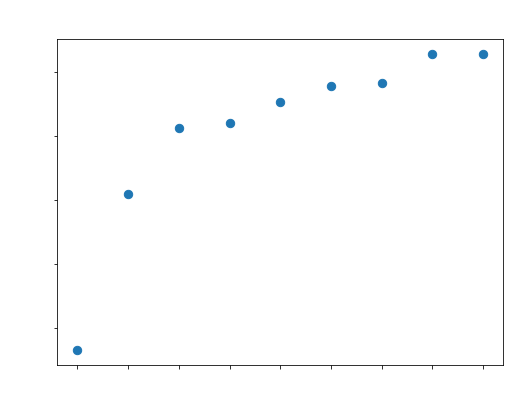

In [ ]:
# plot distance of all the recommendations obtained from the classifier
plt.figure(figsize=(8, 6))
arr = np.array([1,2,3,4,5,6,7,8,9])
plt.scatter(arr, distances[0][1:]*100, s=70)
plt.xlabel("i-th recommended item", labelpad = 15)
plt.ylabel("cosine similarity score (%)", labelpad = 15)
plt.title("Pairwise Cosine similarity scores (%) of recommended items", y=1.05);
plt.tick_params(labelsize=12, pad=6);
plt.tick_params(labelcolor="white");
plt.show()

# Save the Model
We finally need to save the model to deploy it to production.
To do this we save our trained knn model as a pickle file and use that knn file in our project.

In [ ]:
import pickle

In [ ]:
filename='model.pkl'
knnPickle = open(filename, 'wb') # wb means : write in binary 
pickle.dump(model_knn, knnPickle) # dump methods says to store the model named model_knn to file named knnpickle

In [ ]:
filename='dataframe.pkl'
dfPickle = open(filename, 'wb') 
pickle.dump(product_features_df, dfPickle)

# Making predictions
Finally, we load the saved model and use that to make some predictions

In [ ]:
query_index = 3
import pickle
loaded_model = pickle.load(open("model.pkl","rb"))
loaded_df = pickle.load(open("dataframe.pkl","rb"))
distances, indices = loaded_model.kneighbors(loaded_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = n_neighbors)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(product_features_df.index[query_index]))
    else:
        print('{0}: {1}'.format(i, product_features_df.index[indices.flatten()[i]]))

Recommendations for  HDE Universal Mobile Cell Phone Battery Charger:

1: Replacement Battery for Microsoft Zune 2nd 16G/32G/64G, DOCA 3.7V Rechargeable Battery with Opening Pry Tool Kits - Compatible for Zune 2nd HD
2: Motorola Buds SF500 Universal Bluetooth Ear Bud Stereo Headset - Retail Packaging - White
3: Motorola BLT-04 Bluetooth Headset Carrying Case
4: OtterBox Defender Case for BlackBerry Curve 8300 Series (Black)
5: OtterBox 2000-20 WaterProof Universal Case - Black (Discontinued by Manufacturer)
6: OEM Original Detachable Ac Power Cord (8-CDP-P300) for Zojirushi hot Water Dispensing Pot CD-LCC30/40/50, CD-EPC22/30, CD-FAC22, CD-JSC22/30, CD-WBC30/40, CV-DSC40, CW-PZC22/30
7: OEM MOTOROLA BR50 Battery RAZR V3 V3c V3m V3e V3i V3t
8: OEM MOTOROLA SNN5696 BR50 RAZR V3 V3c V3m BATTERY
9: Nokia E51 Unlocked Phone with 2 MP Camera, 3G, Wi-Fi, MP3/Video Player, and MicroSD Slot--U.S. Version with Warranty (Black Steel)
